# Un Studiu al Tehnicilor Steganografice
Mai jos se regăsește codul de implementare pentru algoritmii discutați în cadrul lucrării de licență.

Următoarele librării trebuie instalate pentru buna funcționare a scripturilor Python.

In [ ]:
# Need to be Installed
!pip install pillow
!pip install pycryptodome
!pip install pyaes pbkdf2
!pip install bitstring

# *Algoritmul LSB Naiv*
Mesajul secret va fi încorporat în bitul cel mai nesemnificativ din fiecare canal al culorii unui pixel.
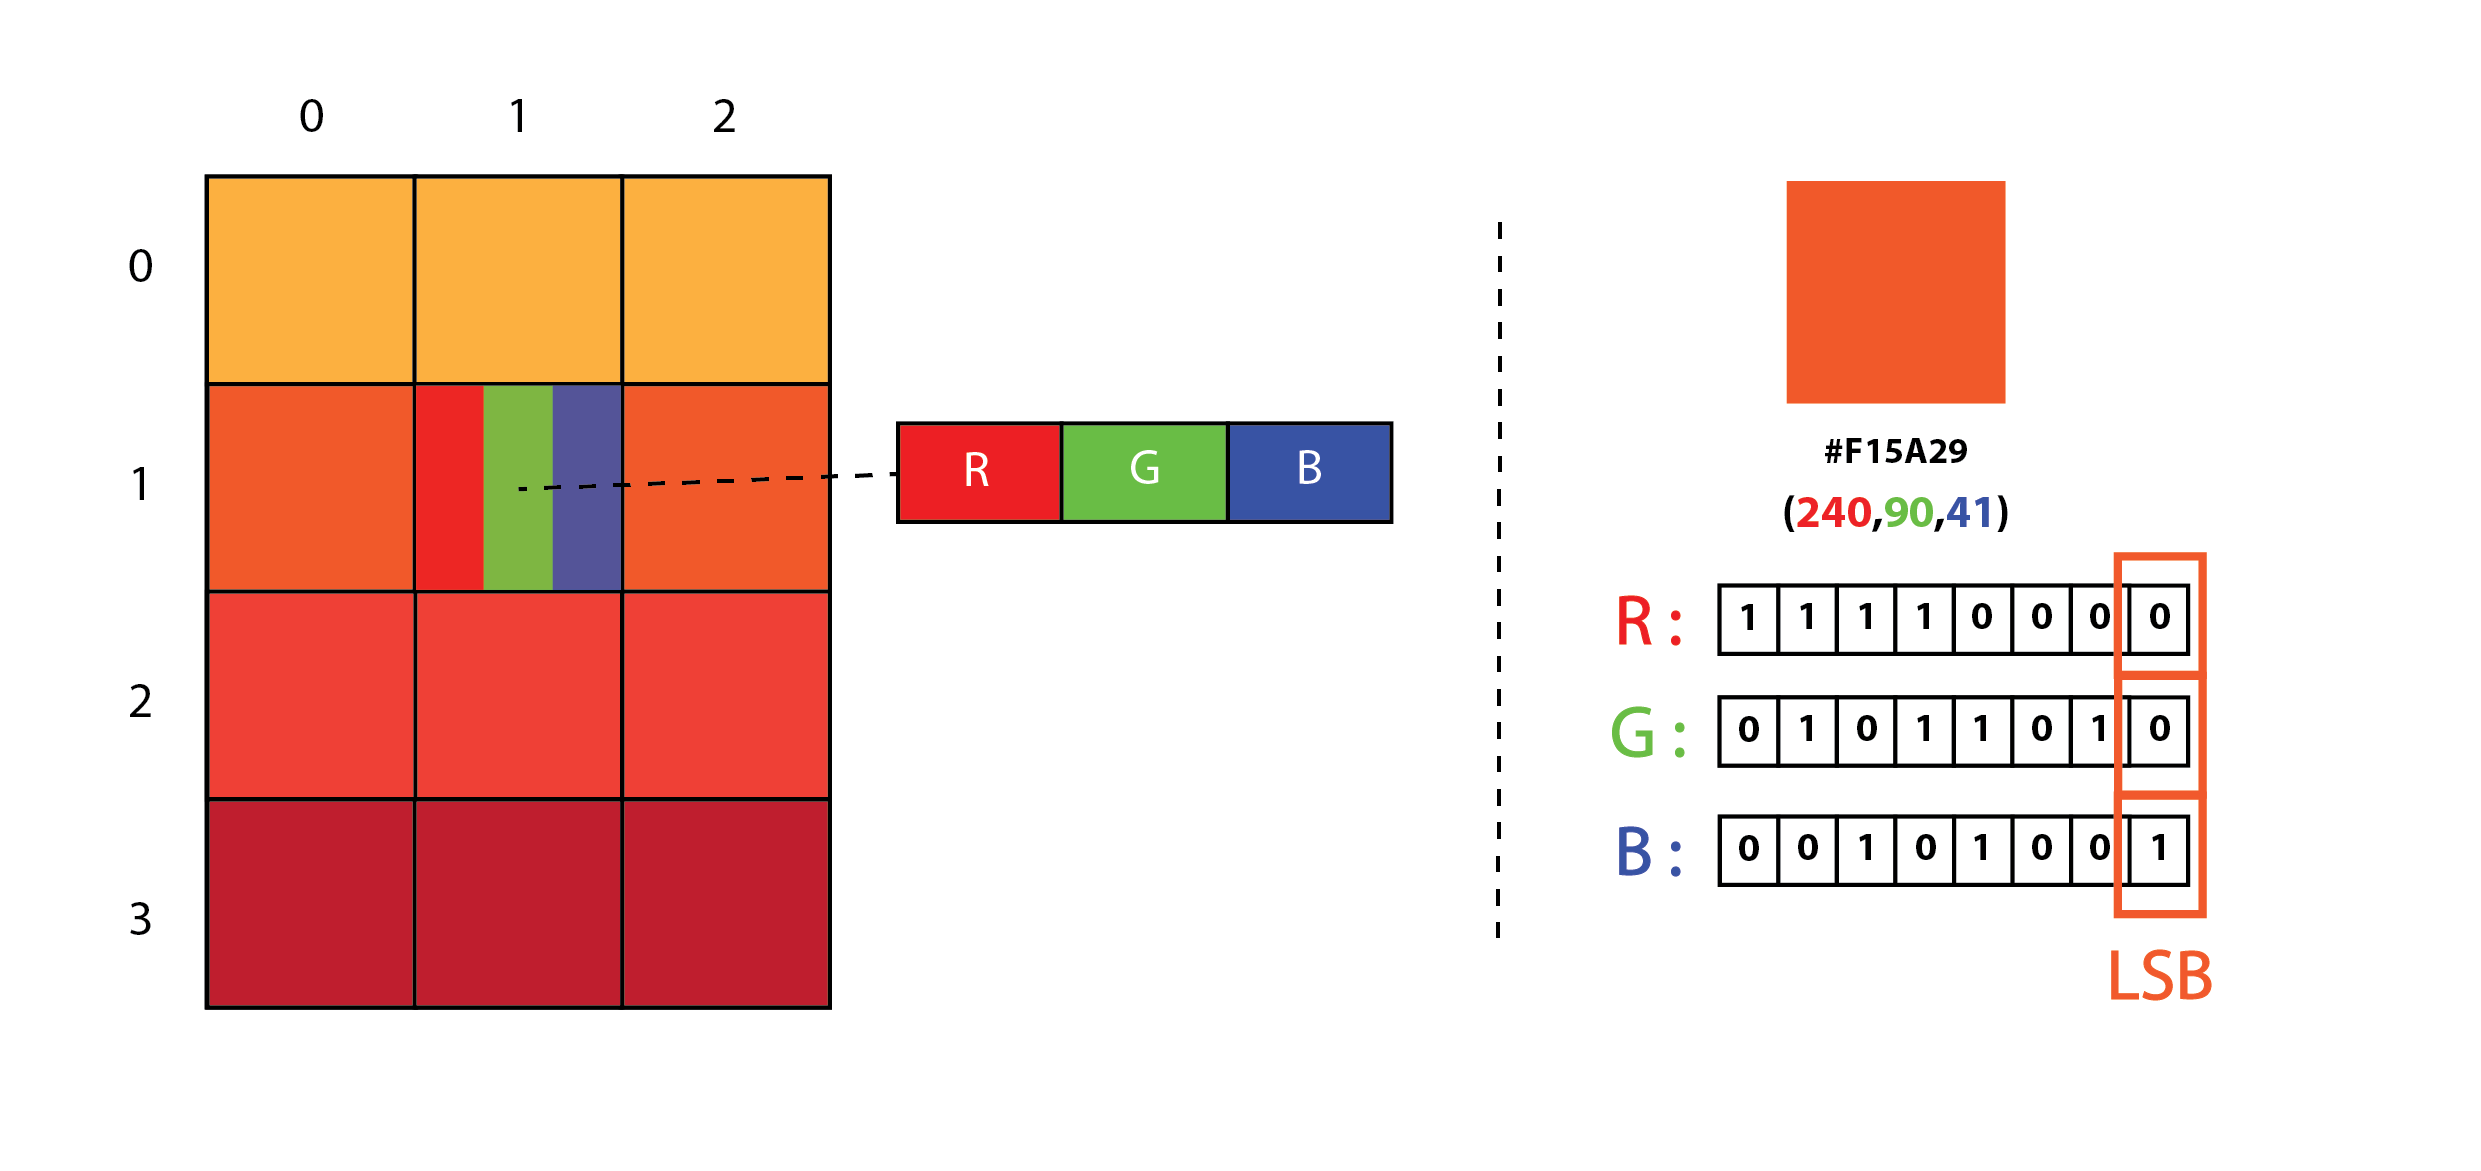

In [ ]:
"""              Algoritmul LSB Naiv              """
# Biblioteci
from PIL import Image     # pentru operații simple asupra pozelor





# Funcție care transformă orice tip de dată în binar
def textToBinary(text):
		aux = []
		for i in text:
			aux.append(format(ord(i), '08b'))    # ord -> caracter în Unicode; 08b -> format pe 8 biți
		return aux



# Funcție care encodează mesajul secret în pixelii din imagine
def messageInPixel(pixel, text): 
    textB = textToBinary(text)        # transform mesajul secret în binar
    lenTextB = len(textB) 
    iterator = iter(pixel) 
  
    # pt fiecare byte din mesajul secret binar
    for i in range(lenTextB): 
        # Extrag câte 3 pixeli o dată (= 9 bytes)
        pixel = [value for value in iterator.__next__() + iterator.__next__() + iterator.__next__()] 

        # Schimb val pixelilor în funcție de mesajul secret (pt fiecare bit din byte-ul mesajului secret)
        for j in range(0, 8): 
            # modific biții doar dacă aceștia nu corespund (Statistic vorbind, doar jumătate din biții dintr-o imagine vor trebui să fie modificați)
            if (textB[i][j] == '0') and (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textB[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # Al 9-lea bit: 0 - continuă citire; 1 - stop (tot mesajul a fost complet codat)  
        if (i == lenTextB - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        # întorc pixelii modificați ca să construiesc noua fotografie steganografică
        pixel = tuple(pixel) 
        yield pixel[0:3]      # câte un pixel (3 canale de culoare)
        yield pixel[3:6] 
        yield pixel[6:9]
        


# Funcție care încorporează mesajul secret în poză       
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Pun pixelii modifcați în imagine (Construirea Obiectului Steganografic)
        # Parcurg poza de sus în jos, de la stânga la dreapta (secvențial)
        img.putpixel((x, y), pixel)   # punem câte un pixel (3 canale de culoare) pe poziție
        if (x == w - 1):              # așa mă deplasez prin fotografie
            x = 0
            y += 1
        else: 
            x += 1
            


# Funcția Principală pentru Încorporare Mesaj Secret în Poză
def encode(): 
    img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open(img, 'r') 

    text = input("Introduceti Mesajul Secret: ") 
    if (len(text) == 0): 
        raise ValueError('Mesajul secret nu poate fi gol!')

    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
    imgAux.save(newImg, str(newImg.split(".")[1].upper()))



# Funcția Principală care Extrage Mesajul Secret din Poză
def decode(): 
    img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__() + imgdata.__next__() + imgdata.__next__()] 
        # String biți
        binstr = '' 

        # mă interesează primii 8 bytes (al 9-lea e dacă am ajuns la final sau nu)  
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2))   # chr -> întoarce caracter din unicode
        # Dacă am ajuns la finalul mesajului secret ( = 1)
        if (pixels[-1] % 2 != 0): 
            return text
        


# Algoritm LSB Simplu  
def LSB_Simplu(): 
    choice = int(input(":::    LSB Simplu    :::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (choice == 1): 
        encode()     
    elif (choice == 2): 
        print("Mesajul secret: " + decode()) 
    else: 
        raise Exception("Input incorect!")
    


LSB_Simplu()

# *Algoritmul LSB prin Liste Înlănțuite*
Această metodă aduce câteva îmbunătățiri importante algoritmului de bază. În primul rând, mesajul secret nu mai este încorporat în pixeli consecutivi, ci se folosește conceptul de listă înlănțuită: în canalul roșu al pixelului încorporăm mesajul secret, în cel verde avem coordonata X pentru poziția următorul pixel și în canalul albastru codăm coordonata Y a următorului pixel. Pentru a putea decodifica mesajul, avem nevoie de poziția primului pixel (asa cum am avea nevoie de adresa rădăcinii listei înlănțuite).
1.png

In [ ]:
"""              Algoritmul LSB Liste Înlănțuite              """
# Biblioteci
from PIL import Image
import binascii               # operații între binar și ASCII
from random import choice     # pentru generare numere aleatoare





def nrPixelInCoordonate(nr, img):
    """
        Întoarcem coordonatele pixelului în imaginea img, pornind de la nr pixelului.
        Ex: img are L = 10, l = 5 și ne interesează pixelul 11
        ---> Coordonate: (1, 0)
    """
    return (nr%img.size[0], nr//img.size[0])


def coordonateInNrPixel(x, y, img):
    # Operația inversă a funcției de mai sus
    return int(y * img.size[0] + x)





# Modific LSB în funcție de mesajul secret (binar)
def setLSB(pix, dateSecrete):
    if dateSecrete == "0":
        return pix & 0b11111110
    elif dateSecrete == "1":
        return pix | 0b00000001





# Text în Binar
def textToBinary(text):
    return ''.join(format(ord(x), '08b') for x in text)


# Împărțim în Blocuri
def chunkstring(text, lungime):
    return [text[0+i:lungime+i].ljust(lungime, "0") for i in range(0, len(text), lungime)]





def encodeAux(text, pixel, nextP, img):
    pix = img.load()
    x, y = nrPixelInCoordonate(nextP, img)
    l = len(text)
    # coordonata x pt nextP în binar
    col = bin(x)[2:].zfill(l)               # bin -> pune 0b în fața valorii binare, deci tb să o scoatem
    # coordonata y pt nextP în binar
    lin = bin(y)[2:].zfill(l)
    
    # iau pixeli consecutivi pt a coda un byte (sărim la alt pixel pt un byte nou)
    for i in range(pixel, pixel + l):
        p = pix[nrPixelInCoordonate(i, img)]
        pix[nrPixelInCoordonate(i, img)] = (
            setLSB(p[0], text[i-pixel]),
            setLSB(p[1], col[i-pixel]),
            setLSB(p[2], lin[i-pixel]))


def encode(text, imgIn, imgOut, startingPixel=(0,0)):
    img = Image.open(imgIn)
    # selectăm dimensiunea blocului mai mare (în funcție de poză) pt timp mai bun
    BLOCKLEN = len(bin(max(img.size))[2:])
    total = img.size[0] * img.size[1]
    # listă blocuri pixeli libere
    AVAILABLE = [x for x in range(1, total-1, BLOCKLEN)]
    # verific dacă ultimul bloc e suficient de mare
    if AVAILABLE[-1] + BLOCKLEN >= total:
        AVAILABLE.pop()

    d = chunkstring(textToBinary(text), BLOCKLEN)
    n = len(d)
    # primul pixel după coordonatele date
    pixel = coordonateInNrPixel(startingPixel[0], startingPixel[1], img)
    if pixel == 0:
        # (0, 0) nu poate fi primul pixel
        pixel = choice(AVAILABLE)
        AVAILABLE.remove(pixel)
        startingPixel = nrPixelInCoordonate(pixel, img)
    for i in range(n-1):
        # pointer pt următorul pixel
        nextP = choice(AVAILABLE)
        AVAILABLE.remove(nextP)
        encodeAux(d[i], pixel, nextP, img)
        # trec la următorul pixel
        pixel = nextP
    # ultimul pointer care întoarce NULL (0, 0)
    encodeAux(d[n-1], pixel, 0, img)
    img.save(imgOut)
    img.close()
    # avem nevoie de pixelul "rădăcină"
    return startingPixel





def binaryToText(text):
    # ne asigurăm că avem multiplu de 8 biți
    # punem padding altfel
    if len(text) % 8 != 0:
        r = 8 - (len(text) % 8)
        text = text + "0" * r
    
    h = hex(int(text, 2))[2:]
    if len(h) % 2 != 0:
        h = "0" + h
    # scoatem ultimul byte NULL (acela care indică finalul)
    return binascii.unhexlify(h)[:-1]     # unhexlify are nevoie de număr par de caractere 


def decodeAux(img, startX, startY):
    n = coordonateInNrPixel(startX, startY, img)
    pix = img.load()
    BLOCKLEN = len(bin(max(img.size))[2:])
    nx = ""
    ny = ""
    s = ""
    for i in range(BLOCKLEN):
        c = nrPixelInCoordonate(n+i, img)
        s += str(pix[c][0] & 1)
        nx += str(pix[c][1] & 1)
        ny += str(pix[c][2] & 1)
    nx = int(nx, 2)
    ny = int(ny, 2)
    return (s,(nx, ny))


def decode(imgName, startX, startY):
    img = Image.open(imgName)
    data, p = decodeAux(img, startX, startY)
    while p != (0, 0):
        d, p = decodeAux(img, p[0], p[1])
        data += d
    d, p = decodeAux(img, p[0], p[1])
    data += d
    return binaryToText(data)





# Algoritm LSB Liste  
def LSB_Liste(): 
    choice = int(input(":::    LSB Liste    :::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (choice == 1): 
        img = input("Introduceti Imaginea cu extensie: ") 

        text = input("Introduceti Mesajul Secret: ") 
        if (len(text) == 0): 
            raise ValueError('Mesajul secret nu poate fi gol!')
        
        newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
        
        r = encode(text, img, newImg)  
        print(f"Cheie Secreta: {r}")
        
    elif (choice == 2): 
        img = input("Introduceti Imaginea cu extensie: ") 
        x = input("Introduceti coordonata X a cheii: ") 
        y = input("Introduceti coordonata Y a cheii: ") 
        print(decode(img, int(x), int(y))) 
        
    else: 
        raise Exception("Input incorect!")
    


LSB_Liste()

# *Algoritmul LSB prin K-means Clustering*
Asupra imaginii de acoperire se aplică algoritmul de K-Means și se formează 3 clustere (se poate alege un număr mai mare de clustere dacă avem un mesaj mai lung sau dacă vrem să creăm confuzie). Pixelii sunt repartizați în cele trei clustere, care sunt convertite, mai departe, în fotografii de sine-stătătoare. În următorul pas, mesajul secret este criptat și împărțit în trei fragmente de lungime egală; iar fiecărui fragment îi este repartizat o fotografie și este încodat în aceasta folosind tehnica LSB. Important de reținut este faptul că culorile nu sunt distribuite egal și ne așteptăm ca unele clustere să fie mai mari decât altele. Astfel, dacă avem un mesaj de o dimensiune mai ridicată și facem împărțirea acestuia în trei bucăți egale, așa cum este descris în algoritmul original, este posibil să avem pierdem din mesajul transmis, de aceea, o posibilă îmbunătățire ar fi să împărțim mesajul în trei bucăți direct proporționale cu dimensiunea celor trei clustere obținute.

In [ ]:
"""              Algoritmul LSB K-Means Clustering              """
# Biblioteci
import cv2           # pentru lucrul cu fotografiile, dar conține operații mai complexe
import numpy as np
import math
from PIL import Image





def KMeansClustering(poza):
  img = cv2.imread(poza)
  Img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # cv2 citește canalele invers și trebuie să le repui în ordine

  # Tutorial pentru K-Means (documentație oficială): https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
  """
      Input parameters
        samples : It should be of np.float32 data type, and each feature should be put in a single column.
        nclusters(K) : Number of clusters required at end
        criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:
        type of termination criteria. It has 3 flags as below:
        cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
        cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
        cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
        max_iter - An integer specifying maximum number of iterations.
        epsilon - Required accuracy
        attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.
        flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

      Output parameters
        compactness : It is the sum of squared distance from each point to their corresponding centers.
        labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
        centers : This is array of centers of clusters.
  """
  vector_img = Img.reshape((-1, 3))      # un vector cu 3 coloane
  vector_img = np.float32(vector_img)    # conform documentației
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
  compactness, labels, centers = cv2.kmeans(vector_img, 3, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  # salvăm poza nouă după ce am aplicat algoritmul K-Means Clustering
  centers = np.uint8(centers)
  res = centers[labels]
  res_image = res.reshape((Img.shape))
  clustered_img = Image.fromarray(res_image)
  clustered_img.save('clustered_img.png')

  # 3 fotografii, corespunzătoare celor 3 clustere (unde vom ascunde mesajul secret)
  # împărțim pixelii în cele 3 clustere corespunzătoare
  image_one_array = []
  image_two_array = []
  image_three_array = []
  for i in range(0, len(labels)):
    if labels[i][0] == 0:
      image_one_array.append(vector_img[i])
    elif labels[i][0] == 1:
      image_two_array.append(vector_img[i])
    else:
      image_three_array.append(vector_img[i])
    
  len1 = len(image_one_array)
  len2 = len(image_two_array)
  len3 = len(image_three_array)

  pad1 = math.ceil(math.sqrt(len1))**2 - len1
  pad2 = math.ceil(math.sqrt(len2))**2 - len2
  pad3 = math.ceil(math.sqrt(len3))**2 - len3

  # padding ca să facem fotografiile
  white = np.array([255.0, 255.0, 255.0], dtype=np.float32)

  for i in range(0, pad1): image_one_array.append(white)
  for i in range(0, pad2): image_two_array.append(white)
  for i in range(0, pad3): image_three_array.append(white)

  d1 = int(math.sqrt(len(image_one_array)))
  d2 = int(math.sqrt(len(image_two_array)))
  d3 = int(math.sqrt(len(image_three_array)))

  cluster1 = np.uint8(np.array(image_one_array)).reshape((d1, d1, 3))
  cluster2 = np.uint8(np.array(image_two_array)).reshape((d2, d2, 3))
  cluster3 = np.uint8(np.array(image_three_array)).reshape((d3, d3, 3))

  # salvăm fotografiile (clusterele) unde vom coda mesajul secret
  cluster1_img = Image.fromarray(cluster1)
  cluster1_img.save('cluster1_img.png')

  cluster2_img = Image.fromarray(cluster2)
  cluster2_img.save('cluster2_img.png')

  cluster3_img = Image.fromarray(cluster3)
  cluster3_img.save('cluster3_img.png')





#######             LSB Simplu             #######
# Funcție care transformă orice tip de dată în binar
def textToBinary(text):
		aux = []
		for i in text:
			aux.append(format(ord(i), '08b'))    # ord -> caracter în Unicode; 08b -> format pe 8 biți
		return aux



# Funcție care encodează mesajul secret în pixelii din imagine
def messageInPixel(pixel, text): 
    textB = textToBinary(text)        # transform mesajul secret în binar
    lenTextB = len(textB) 
    iterator = iter(pixel) 
  
    # pt fiecare byte din mesajul secret binar
    for i in range(lenTextB): 
        # Extrag câte 3 pixeli o dată (= 9 bytes)
        pixel = [value for value in iterator.__next__() + iterator.__next__() + iterator.__next__()] 

        # Schimb val pixelilor în funcție de mesajul secret (pt fiecare bit din byte-ul mesajului secret)
        for j in range(0, 8): 
            # modific biții doar dacă aceștia nu corespund (Statistic vorbind, doar jumătate din biții dintr-o imagine vor trebui să fie modificați)
            if (textB[i][j] == '0') and (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textB[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # Al 9-lea bit: 0 - continuă citire; 1 - stop (tot mesajul a fost complet codat)  
        if (i == lenTextB - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        # întorc pixelii modificați ca să construiesc noua fotografie steganografică
        pixel = tuple(pixel) 
        yield pixel[0:3]      # câte un pixel (3 canale de culoare)
        yield pixel[3:6] 
        yield pixel[6:9]
        


# Funcție care încorporează mesajul secret în poză       
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Pun pixelii modifcați în imagine (Construirea Obiectului Steganografic)
        # Parcurg poza de sus în jos, de la stânga la dreapta (secvențial)
        img.putpixel((x, y), pixel)   # punem câte un pixel (3 canale de culoare) pe poziție
        if (x == w - 1):              # așa mă deplasez prin fotografie
            x = 0
            y += 1
        else: 
            x += 1
            


# Funcția Principală pentru Încorporare Mesaj Secret în Poză
def encode(poza, text, pozaFinala): 
    image = Image.open(poza, 'r') 
    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    imgAux.save(pozaFinala, str(pozaFinala.split(".")[1].upper()))



# Funcția Principală care Extrage Mesajul Secret din Poză
def decode(img): 
    image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__() + imgdata.__next__() + imgdata.__next__()] 
        # String biți
        binstr = '' 

        # mă interesează primii 8 bytes (al 9-lea e dacă am ajuns la final sau nu)  
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2))   # chr -> întoarce caracter din unicode
        # Dacă am ajuns la finalul mesajului secret ( = 1)
        if (pixels[-1] % 2 != 0): 
            return text





# Algoritm LSB K-Means Clustering 
def LSB_KMeans(): 
    choice = int(input(":::    LSB K-Means Clustering    :::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (choice == 1): 
        img = input("Introduceti Imaginea cu extensie: ") 
        KMeansClustering(img)

        text = input("Introduceti Mesajul Secret: ") 
        if (len(text) == 0): 
            raise ValueError('Mesajul secret nu poate fi gol!')
        # împărțim în 3 bucăți egale mesajul (recomandat ar fi să împărțim direct proporțional cu dimensiunea clusterelor)
        div_len = int(len(text)//3)
        chunk1 = text[0:div_len]
        chunk2 = text[div_len: 2*div_len]
        chunk3 = text[2*div_len:]

        image_encoded1 = encode('cluster1_img.png', chunk1, 'a.png')
        image_encoded2 = encode('cluster2_img.png', chunk2, 'b.png')
        image_encoded3 = encode('cluster3_img.png', chunk3, 'c.png')
        

    elif (choice == 2): 
        decoded_chunk1 = decode('a.png')
        decoded_chunk2 = decode('b.png')
        decoded_chunk3 = decode('c.png')

        mesajSecret = decoded_chunk1 + decoded_chunk2 + decoded_chunk3
        print("Mesajul secret: ", mesajSecret)
        
    else: 
        raise Exception("Input incorect!")
    


LSB_KMeans()

# *Algoritmul LSB Propus: AES și Pixeli Random*
În cele ce urmează, vom propune un algoritm de steganografie bazat pe tehnica LSB. Motivul alegerii acestei metodologii se datorează faptului că, în literatura de specialitate, este bine-cunoscut că un algoritm steganografic folosind LSB este mai vulnerabil decât alte tehnici. 

> Un prim pas logic constă în criptarea mesajului. În acest fel, se face legătura dintre criptografie și steganografie, iar securitatea algoritmului este îmbunătățită substanțial. Pentru criptarea mesajului secret vom folosi algoritmul AES, un algoritm simetric, rapid și care se realizează fără pierderea anumitor date din memorie.

> În continuare, pentru a îmbunătăți securitatea algoritmului LSB, vom lua în considerare faptul că este slab împotriva atacurilor de steganaliză din princina pixelilor modificați care sunt așezați unul după altul. De aceea, propunem să îi amestecăm, pentru a putea folosi întreaga capacitate a fotografiei de acoperire și a crește gradul de siguranță. Pentru a obține acest lucru, vom folosi versiunea modernă a algoritmului de amestecare Fisher-Yates (versiunea lui Durstenfeld).

Metoda propusă nu este foarte eficientă din punct de vedere al memoriei deoarce trebuie să trimitem secvența criptată de pixeli, alături de imaginea rezultată prin tehnica steganografică, dar facem acest compromis pentru a obține o mai bună securitate.





In [47]:
"""              Algoritmul LSB Propus              """
# Biblioteci
import os         
import binascii
import pbkdf2
import pyaes
import hashlib
import random
import numpy as np
from PIL import Image
import struct
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes







########################################      CRIPTARE + DECRIPTARE MESAJ
# https://cryptobook.nakov.com/symmetric-key-ciphers/aes-encrypt-decrypt-examples
# trebuie să fie aceleași și pt criptare și pt decriptare
passwordSalt = b'\\`\xd6\xdaB\x03\xdd\xd4z\xb6p\xe8O\xf0\xa8\xc0'
iv = 12276418801510358845029257473125458269416880639997527613362129559241916371076
def encrypt(text, parola):
    """
        Derives a 256-bit key using the PBKDF2 key derivation algorithm from the password. It uses a random 
        password derivation salt (128-bit). This salt should be stored in the output, together with the ciphertext, 
        because without it the decryption key cannot be derived again and the decryption will be impossible.
        The derived key consists of 64 hex digits (32 bytes), which represents a 256-bit integer number.
    """
    key = pbkdf2.PBKDF2(parola, passwordSalt).read(32)  
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    cipherByte = aes.encrypt(text)
    return binascii.hexlify(cipherByte).decode('utf-8')   # hex digits

def decrypt(text, parola):
    res = bytes(text, 'utf-8')
    cipherByte = binascii.unhexlify(res)
    key = pbkdf2.PBKDF2(parola, passwordSalt).read(32)
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    originalByte = aes.decrypt(cipherByte)
    return originalByte.decode('utf-8')





###################################################     CRIPTARE + DECRIPTARE FIȘIER PIXELI
# https://www.novixys.com/blog/using-aes-encryption-decryption-python-pycrypto/
def encrypt_file(key, in_filename, out_filename=None, chunksize=64 * 1024):
    if not out_filename:
        out_filename = in_filename + '.enc'
    iv = get_random_bytes(AES.block_size)
    encryptor = AES.new(key, AES.MODE_CBC, iv)
    filesize = os.path.getsize(in_filename)
    with open(in_filename, 'rb') as infile:
        with open(out_filename, 'wb') as outfile:
            outfile.write(struct.pack('<Q', filesize))
            outfile.write(iv)
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                elif len(chunk) % 16 != 0:
                    chunk += b' ' * (16 - len(chunk) % 16)

                outfile.write(encryptor.encrypt(chunk))


def decrypt_file(key, in_filename, out_filename=None, chunksize=24 * 1024):
    if not out_filename:
        out_filename = os.path.splitext(in_filename)[0]
    with open(in_filename, 'rb') as infile:
        origsize = struct.unpack('<Q', infile.read(struct.calcsize('Q')))[0]
        iv = infile.read(16)
        decryptor = AES.new(key, AES.MODE_CBC, iv)
        with open(out_filename, 'wb') as outfile:
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                outfile.write(decryptor.decrypt(chunk))

            outfile.truncate(origsize)





# Funcție care transformă orice tip de dată în binar
def textToBinary(text):
    binar = list(format(c, '08b') for c in bytearray(text.encode('latin-1')))
    return binar


def PixeliRandom(width, height, lenEncodedMessage):
    new = []
    Pixeli = []
    for i in range(width * height):
        new.append(i)
    for i in range(len(new) - 1, 0, -1):
        j = random.randint(0, i + 1)
        new[i], new[j] = new[j], new[i]
    for i in range(lenEncodedMessage * 3):
        Pixeli.append(new[i])
    vectorPixeli = np.array(Pixeli)
    np.savetxt("pixeliSecventa.txt", vectorPixeli, delimiter="\t")
    return Pixeli


def encodeAux(imgAux, encodedMessage): 
    width, height = imgAux.size
    # creez secvența de pixeli amestecați
    Pixeli = PixeliRandom(width, height, len(encodedMessage))
    textB = textToBinary(encodedMessage)  
    dr = 0
    for i in range(0, len(encodedMessage) * 3, 3):
        dc = 0
        for j in range(0, 3):
            rr = Pixeli[i + j] // height
            rc = Pixeli[i + j] % height
            rgb = imgAux.getpixel((rr, rc))
            value = []
            idx = 0
            for k in rgb:
                if (k % 2 == 0 and textB[dr][dc] == '1'):
                    if (k == 0):
                        k += 1
                    else:
                        k -= 1
                if (k % 2 == 1 and textB[dr][dc] == '0'):
                    k -= 1
                value.append(k)
                idx += 1
                dc += 1
                if (dc >= 8):
                    break
            if (dc >= 8):
                value.append(rgb[2])
            newrgb = (value[0], value[1], value[2])
            imgAux.putpixel((rr, rc), newrgb)
        dr += 1
    
    newImg = input("Introduceti Numele Pozei Noi cu extensie: ") 
    imgAux.save(newImg, str(newImg.split(".")[1].upper()))
    passPix = input("Parola Pentru Pixeli: ")
    # ca să verificăm validitatea cheii
    key = hashlib.sha256(passPix.encode()).digest()
    encrypt_file(key, 'pixeliSecventa.txt')
         

# Funcția Principală pentru encodare
def encode(): 
    img = input("Introduceti Imaginea cu extensie: ") 
    image = Image.open(img, 'r') 

    text = input("Introduceti Mesajul Secret: ") 
    if (len(text) == 0): 
        raise ValueError('Mesajul secret nu poate fi gol!') 
    
    # parolă pentru mesaj
    passwordText = input("Parola pentru mesaj: ")
    encodedMessage = encrypt(text, passwordText)    # am codat textul cu parola dată

    imgAux = image.copy() 
    width, height = imgAux.size

    # Verific ca dimensiunea mesajului secret să nu fie mai mare decât capacitatea pozei
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insuficienti bytes: alegeti o poza cu dimensiuni mai mari sau reduceti marimea mesajului!\nNr maxim de bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, encodedMessage)





# Funcția Principală pentru decodare
def decode(): 
    passPix = input("Parola pentru Pixeli: ")
    key = hashlib.sha256(passPix.encode()).digest()
    decrypt_file(key, 'pixeliSecventa.txt.enc', 'out.txt')
    Pixeli = np.genfromtxt('out.txt', delimiter='\t')

    if os.path.exists("out.txt"):
        os.remove("out.txt")
    if os.path.exists("pixeliSecventa.txt.enc"):
        os.remove("pixeliSecventa.txt.enc")

    decodedTextInBits = []
    imgOut = input("Introduceti Imaginea Stego cu extensie: ") 
    img = Image.open(imgOut, 'r') 
    width, height = img.size
    for i in range(0, len(Pixeli), 3):
        ithChar = ""
        for j in range(0, 3):
            rr = Pixeli[i + j] // height
            rc = Pixeli[i + j] % height
            rgb = img.getpixel((rr, rc))
            for k in rgb:
                if (k & 1):
                    ithChar += '1'
                else:
                    ithChar += '0'

        ithChar = ithChar[:-1]
        decodedTextInBits.append((ithChar))
    decodedText = ''
    for i in decodedTextInBits:
        decodedText += chr(int(i, 2))
    return decodedText





# Algoritm LSB Propus
def LSB_Propus(): 
    choice = int(input(":::    LSB Propus   :::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (choice == 1): 
        encode()

    elif (choice == 2): 
      if os.path.exists("pixeliSecventa.txt.enc"):
        decodedText = decode()
        password = input("Parola Pentru Mesaj: ")
        mesajSecret = decrypt(decodedText, password)
        print("Mesajul secret: ", mesajSecret)
      else: 
        raise Exception("Nu exista fisierul cu pixelii!")
    


LSB_Propus()

:::    LSB Propus   :::
1. Codare
2. Decodare
2
Parola pentru Pixeli: 456
Introduceti Imaginea Stego cu extensie: out1.png
Parola Pentru Mesaj: 123
Mesajul secret:  Ana are mere Tam Tam Somnoroase pasarele pe la cuiburi se aduna se ascund in ramurele noapte buna aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc Ana are mere Tam Tam Somnoroase pasarele pe la cuiburi se aduna se ascund in ramurele noapte buna aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc Ana are mere Tam Tam Somnoroase pasarele pe la cuiburi se aduna se ascund in ramurele noapte buna aaaaaaaaaaaaaaaaaaa

# *Algoritmul DCT*
Tehnicile steganografice pot fi clasificate în metode aplicate în domeniul spațial și metode aplicate în domeniul de frecvență. Până acum au fost prezentate doar metode care făceau uz de domeniul spațial și anume algoritmii de tip LSB, deoarece procesarea se aplică direct asupra valorilor pixelilor din imaginea de acoperire. Aceste metode sunt utilizate pe scară largă datorită simplității lor. Cu toate acestea, sunt extrem de vulnerabile la modificări, chiar și mici, care au fost aplicate fișierului de acoperire.

---


Algoritmul Jsteg este o versiune modificată a algoritmului de codificare JPEG standardizat și a fost inventat de Derek Upham. Ideea principală din spatele acestui algoritm este de a manipula porțiunea (DCT) a procesului standard de codificare JPEG pentru a încorpora datele secrete.

In [ ]:
"""              Algoritmul DCT              """
# Biblioteci
import cv2
import struct
import bitstring
import numpy  as np





# Zigzag parcurgere matrice
def zigzag(input):
	w = 0
	h = 0

	wmin = 0
	hmin = 0

	wmax = input.shape[0]
	hmax = input.shape[1]

	output = np.zeros((wmax * hmax))
    
	i = 0
	while ((w < wmax) and (h < hmax)):
		if ((h + w) % 2) == 0:                 # în sus

			if (w == wmin):                    # prima linie
				#print(1)
				output[i] = input[w, h]        
				if (h == hmax):
					w = w + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1) and (w < wmax)):   # ultima coloană
				#print(2)
				output[i] = input[w, h]
				w = w + 1
				i = i + 1

			elif ((w > wmin) and (h < hmax -1 )):    # altfel
				#print(3)
				output[i] = input[w, h]
				w = w - 1
				h = h + 1
				i = i + 1


		else:                                    # în jos
			if ((w == wmax -1) and (h <= hmax -1)):       # ultima linie
				#print(4)
				output[i] = input[w, h]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # prima coloană
				#print(5)
				output[i] = input[w, h]
				if (w == wmax -1):
					h = h + 1
				else:
					w = w + 1

				i = i + 1

			elif ((w < wmax -1) and (h > hmin)):     # altfel
				#print(6)
				output[i] = input[w, h]
				w = w + 1
				h = h - 1
				i = i + 1



		if ((w == wmax-1) and (h == hmax-1)):          # colț dreapta
			#print(7)
			output[i] = input[w, h]
			break


	return output



# Din vector în matrice
def inverse_zigzag(input, wmax, hmax):
	w = 0
	h = 0

	wmin = 0
	hmin = 0

	output = np.zeros((wmax, hmax))

	i = 0
	while ((w < wmax) and (h < hmax)):
		if ((h + w) % 2) == 0:                 # în sus

			if (w == wmin):                    # prima linie
				#print(1)
				output[w, h] = input[i]        
				if (h == hmax):
					w = w + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1 ) and (w < wmax)):   # ultima coloană
				#print(2)
				output[w, h] = input[i]
				w = w + 1
				i = i + 1

			elif ((w > wmin) and (h < hmax -1)):    # altfel
				#print(3)
				output[w, h] = input[i]
				w = w - 1
				h = h + 1
				i = i + 1


		else:                                             # în jos
			if ((w == wmax -1) and (h <= hmax -1)):       # ultima linie
				#print(4)
				output[w, h] = input[i]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # prima coloană
				#print(5)
				output[w, h] = input[i]
				if (w == wmax -1):
					h = h + 1
				else:
					w = w + 1
                    
				i = i + 1

			elif((w < wmax -1) and (h > hmin)):     # altfel
				output[w, h] = input[i]
				w = w + 1
				h = h - 1
				i = i + 1



		if ((w == wmax-1) and (h == hmax-1)):          # colț dreapta
			#print(7)
			output[w, h] = input[i]
			break


	return output





# Matrice Standard de Cuantificare JPEG
MatriceCuantificareStandard = np.asarray([[16, 11, 10, 16,  24, 40,   51,  61],
                                          [12, 12, 14, 19,  26, 58,   60,  55],
                                          [14, 13, 16, 24,  40, 57,   69,  56],
                                          [14, 17, 22, 29,  51, 87,   80,  62],
                                          [18, 22, 37, 56,  68, 109, 103,  77],
                                          [24, 36, 55, 64,  81, 104, 113,  92],
                                          [49, 64, 78, 87, 103, 121, 120, 101],
                                          [72, 92, 95, 98, 112, 100, 103,  99]],
                                        dtype = np.float32)
                                        
# Clasă Imagine YCC pentru a facilita operațiile pe blocuri de 8x8
class Imagine_8x8(object):
    def __init__(self, cover_image):
        self.height, self.width = cover_image.shape[:2]
        self.channels = [split(cover_image[:,:,0]),
                         split(cover_image[:,:,1]),
                         split(cover_image[:,:,2]),]

# împarte imaginea în blocuri de 8x8
def split(img):
    blocks = []
    for vert_slice in np.vsplit(img, int(img.shape[0] / 8)):
        for horiz_slice in np.hsplit(vert_slice, int(img.shape[1] / 8)):
            blocks.append(horiz_slice)
    return blocks

# unește blocurile de 8x8 pt a întregi fotografia    
def join(nrPix, blocks):
    # nrPix -> width
    image_rows = []
    temp = []
    for i in range(len(blocks)):
        if i > 0 and not(i % int(nrPix / 8)):
            image_rows.append(temp)
            temp = [blocks[i]]
        else:
            temp.append(blocks[i])
    image_rows.append(temp)

    return np.block(image_rows)





# Codare / Decodare
def encodeAux(mesajSecret, dct_blocks):
    ok = False        # false = tot mesajul a fost codat; true = nu a putut fi codat tot mesajul
    mesajSecret.pos = 0
    encoded_data_len = bitstring.pack('uint:32', len(mesajSecret))
    converted_blocks = []
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                curr_coeff = np.uint8(current_dct_block[i])
                if (mesajSecret.pos == (len(mesajSecret) - 1)): 
                    ok = True
                    break
                pack_coeff = bitstring.pack('uint:8', curr_coeff)
                if (encoded_data_len.pos <= len(encoded_data_len) - 1): 
                    pack_coeff[-1] = encoded_data_len.read(1)
                else: pack_coeff[-1] = mesajSecret.read(1)
                # Replace converted coefficient
                current_dct_block[i] = np.float32(pack_coeff.read('uint:8'))
        converted_blocks.append(current_dct_block)

    if not(ok): 
        raise ValueError("Mesajul Secret nu s-a codat complet în imagine!")

    return converted_blocks
    
    
def decodeAux(dct_blocks):
    extracted_data = ""
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                extracted_data += bitstring.pack('uint:1', np.uint8(current_dct_block[i]) & 0x01)
    return extracted_data





def encode():
  # Date Inițiale
  nrCanale = 3
  imgIn  = input("Introduceti Imaginea de Intrare cu extensie: ") 
  imgOut  = input("Introduceti Imaginea Stego cu extensie: ") 
  text = input("Introduceti Mesajul Secret: ") 

  # Imaginiea de intrare
  imgInAux = cv2.imread(imgIn, flags = cv2.IMREAD_COLOR)
  height, width   = imgInAux.shape[:2]    # shape are 3 dimeniuni (height, width, noOfChannels)

  # Transformăm în 8x8 poza, dacă nu e
  while(height % 8): height += 1 
  while(width  % 8): width  += 1 
  dimensiuneNoua = (width, height)
  imgPadded    = cv2.resize(imgInAux, dimensiuneNoua)
  
  # lucrăm pe imaginea nouă (dacă am modificat) sau pe ce inițială 
  imgF32 = np.float32(imgPadded)
  # trans RGB -> YCrCb și să putem împărți în blocuri 8x8
  imgYCC = Imagine_8x8(cv2.cvtColor(imgF32, cv2.COLOR_BGR2YCrCb))

  # unde vom pune poza stego
  imgStego = np.empty_like(imgF32)

  # pt fiecare canal
  for i in range(nrCanale):
    # calcul coeficienți DCT
    dct_blocks = [cv2.dct(block) for block in imgYCC.channels[i]]

    # etapă cuantificare
    dct_cuantif = [np.around(np.divide(item, MatriceCuantificareStandard)) for item in dct_blocks]

    # Sort DCT zig-zag
    dct_sort = [zigzag(block) for block in dct_cuantif]

    # Y (luminozitate); restul conferă o nuanță colorată
    if (i == 0):
        # ascundere
        mesajSecret = ""
        for char in text.encode('ascii'): mesajSecret += bitstring.pack('uint:8', char)
        dct_codati   = encodeAux(mesajSecret, dct_sort)
        dct_inversZZ = [inverse_zigzag(block, wmax=8, hmax=8) for block in dct_codati]
    else:
        dct_inversZZ = [inverse_zigzag(block, wmax=8, hmax=8) for block in dct_sort]

    # Decuantificare
    dct_dequants = [np.multiply(data, MatriceCuantificareStandard) for data in dct_inversZZ]

    # IDCT
    idct_blocks = [cv2.idct(block) for block in dct_dequants]

    # Reconstruim canalul imaginii
    imgStego[:,:,i] = np.asarray(join(imgYCC.width, idct_blocks))
#-------------------------------------------------------------------------------------------------#

  # YCR -> BGR (cv2 ca să facă poza are nevoie de BGR)
  imgStegoBGR = cv2.cvtColor(imgStego, cv2.COLOR_YCR_CB2BGR)

  # Clamp Pixel Values to [0 - 255]
  imgFin = np.uint8(np.clip(imgStegoBGR, 0, 255))


  cv2.imwrite(imgOut, imgFin)





def decode():
  img  = input("Introduceti Imaginea cu extensie: ") 
  imgStego     = cv2.imread(img, flags=cv2.IMREAD_COLOR)
  imgStegoF32 = np.float32(imgStego)
  imgStego_YCC = Imagine_8x8(cv2.cvtColor(imgStegoF32, cv2.COLOR_BGR2YCrCb))

  #  DCT
  dct_blocks = [cv2.dct(block) for block in imgStego_YCC.channels[0]]  # doar în Y avem ascunsă info

  # cuantificare
  dct_cuantif = [np.around(np.divide(item, MatriceCuantificareStandard)) for item in dct_blocks]

  # zigzag
  dct_sort = [zigzag(block) for block in dct_cuantif]

  # extragere mesaj
  mesaj = decodeAux(dct_sort)

  # lungime mesaj
  lenMesaj = int(mesaj.read('uint:32') / 8)

  
  extracted_data = bytes()
  for i in range(lenMesaj): 
    extracted_data += struct.pack('>B', mesaj.read('uint:8'))

  print(extracted_data.decode('ascii'))









# Algoritm DCT Modificat
def DCT(): 
    choice = int(input(":::    DCT Modificat   :::\n"
                        "1. Codare\n2. Decodare\n")) 
    
    if (choice == 1): 
        encode()
    elif (choice == 2): 
      decode()
    


DCT()

# *Analiza Performanței*
Va fi realizată folosind histogramele, PSNR, MSE și SSIM.

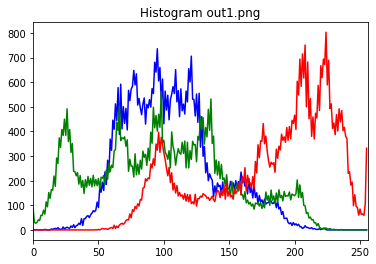

In [48]:
# Histogramă
import cv2
import numpy as np
from matplotlib import pyplot as plt

def histograma(img, string):
  img = cv2.imread(img, -1)
  color = ('b','g','r')
  for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  
  plt.savefig("p"+string, dpi=300, bbox_inches='tight')
  plt.title('Histogram '+string)
  plt.show()

#histograma(numePoza, numePoza)
histograma("out1.png", "out1.png")

In [49]:
# PSNR, MSE, SSIM
import math
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    err = np.sum((original.astype("float") - compressed.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    if (mse == 0):
        return 100
    max_pixel = 255.0
    print("MSE manual: ", mse)
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr



def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    print(f"MSE 2: {mse}")
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))




def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()




def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')



def main():
    original = cv2.imread("in1.png")
    compressed = cv2.imread("out1.png")

    s = calculate_ssim(original, compressed)
    print(f"SSIM manual: {s}")

    value = PSNR(original, compressed)
    print(f"PSNR manual: {value}")

    value = calculate_psnr(original, compressed)
    print(f"PSNR new: {value}")


main()

SSIM manual: 0.9941139252177577
MSE manual:  1.7984460905349795
PSNR manual: 45.581829367473425
MSE 2: 1.8372148148148149
PSNR new: 45.48920422071958
